INPUT: Folder/scenario name\
OUTPUT: CSV file with mean reward, stdev, and metadata. Scatterplot with eval scores.

In [13]:
import json
import os
import numpy as np
import pandas as pd

sanity_check = True

root_dir = f'../sacred/misinform'
search = 'misinform'

def buid_result_df_eval(root_dir):
    # Create empty dataframe
    df = pd.DataFrame()

    # Iterate through each folder
    for root, dirs, files in os.walk(root_dir):
        for file in files:

            # Check for eval directory name if running in mode
            if "eval" not in os.path.join(root, file):
                continue

            if search not in os.path.join(root, file):
                continue

            # Check if info.json and config.json exist
            if 'info.json' in files and 'config.json' in files:

                # Read the info file
                with open(os.path.join(root, 'info.json')) as info_f:
                    data = json.load(info_f)

                # Read the config file
                with open(os.path.join(root, 'config.json')) as config_f:
                    config = json.load(config_f)

                # Extract return_mean and return_mean_T values from the json
                return_mean = [sample['value'] for sample in data['test_return_mean']]
                return_std = [sample['value'] for sample in data['test_return_std']]

                # Put the values in a numpy array
                info_arr = np.array([return_mean, return_std]).T

                # Convert the numpy array to a pandas dataframe
                df_info = pd.DataFrame(info_arr, columns=['return_mean', 'return_stdev'])

                # Loop through the config file and add the variables as columns
                for key, value in config.items():
                    df_info[key] = value
                    # Add variables from sub dict
                    if key == 'env_args':
                        for arg_key, arg_val in value.items():
                            df_info[arg_key] = arg_val
                    df_info['path'] = root

                # Append file info to dataset
                df = pd.concat([df, df_info])
    return df


df = buid_result_df_eval(root_dir)

if df.empty:
    print("No data met the criteria.")   
else:
    # rename mac to algorithm
    df.loc[df['mac']=='n_mac', 'mac'] = 'qmix'
    df.loc[df['mac']=='basic_mac', 'mac'] = 'iql'
    df.rename(columns={'mac': 'algorithm'}, inplace=True)

    df.to_csv(f'../datasets/temp.csv')

Start here if data already exists   
INPUT df_mean\
OUTPUT mean cv table

In [14]:
def get_meta(df, ismean, sort_order):
    if ismean:
        df_mean = df.groupby(['algorithm', 'map_name'])['return_mean'].mean().reset_index()
    else:
        df_mean = df.groupby(['algorithm', 'map_name'])['return_mean'].std().reset_index()
    
    df_cv = df_mean.groupby(['algorithm', 'map_name'])['return_mean'].mean().reset_index()

    iql_mask = df_cv['algorithm'] == 'iql'
    df_iql = df_cv[iql_mask]
    df_qmix = df_cv[~iql_mask]

    # Sort E,M,H
    df_iql.sort_values(by='map_name', key=lambda column: column.map(lambda x: sort_order.index(x)), inplace=True)
    df_qmix.sort_values(by='map_name', key=lambda column: column.map(lambda x: sort_order.index(x)), inplace=True)

    df_cv = pd.concat([df_iql, df_qmix])

    return df_cv

def get_cv(df, sort_order):

    df_return = get_meta(df, ismean=True, sort_order=sort_order)
    df_std = get_meta(df, ismean=False, sort_order=sort_order)

    df_cv = df_return.assign(return_std=df_std['return_mean'])

    return df_cv

In [25]:
import pandas as pd

titles = ['Confidentiality Medium',  'Integrity Medium', 'Availability Medium']
sort_order = ['confidentiality_medium_misinform', 'integrity_medium_misinform', 'availability_medium_misinform']

#df = pd.read_csv('../datasets/baseline_eval.csv')
df_heurisitic = pd.read_csv('../datasets/heuristic/misinform_heuristic.csv')

df_a_cv = get_cv(df, sort_order)
df_h_cv = get_cv(df_heurisitic, sort_order)
df_cv = pd.concat([df_a_cv, df_h_cv])


df_cv.to_csv('../datasets/misinform_eval_cv.csv')
#df.to_csv('./datasets/phase1_eval.csv')
df_h_cv.to_csv('../datasets/heuristic/misinform_heuristic_cv.csv')

print(df_cv)

   algorithm                          map_name  return_mean  return_std
1        iql  confidentiality_medium_misinform   -19.755625    4.182176
2        iql        integrity_medium_misinform   -18.167604    3.860460
0        iql     availability_medium_misinform   -14.473854    2.977429
4       qmix  confidentiality_medium_misinform   -25.066771    7.102700
5       qmix        integrity_medium_misinform   -16.754583    3.476497
3       qmix     availability_medium_misinform   -11.628750    2.841545
1  heuristic  confidentiality_medium_misinform   -67.641617   24.034332
2  heuristic        integrity_medium_misinform   -31.903892   20.727250
0  heuristic     availability_medium_misinform   -21.391617   16.950677


C:\Users\wiebe\AppData\Local\Temp\ipykernel_18132\980666319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iql.sort_values(by='map_name', key=lambda column: column.map(lambda x: sort_order.index(x)), inplace=True)
C:\Users\wiebe\AppData\Local\Temp\ipykernel_18132\980666319.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_qmix.sort_values(by='map_name', key=lambda column: column.map(lambda x: sort_order.index(x)), inplace=True)
C:\Users\wiebe\AppData\Local\Temp\ipykernel_18132\980666319.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

Plot means

['confidentiality_medium_misinform' 'integrity_medium_misinform'
 'availability_medium_misinform']


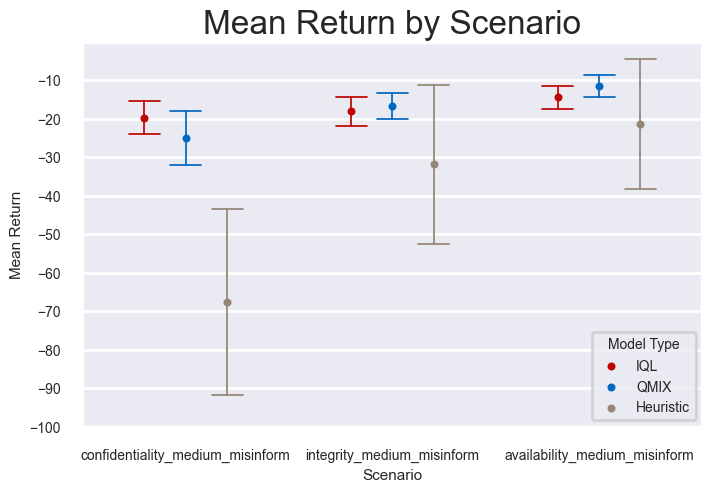

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_pl = pd.concat([df, df_heurisitic])
#df_pl[['scenario', 'network_size']] = df_pl['map_name'].str.split('_', expand=True)

# Sort E,M,H
#df_pl.sort_values(by='map_name', sort_order, inplace=True)
df_pl.sort_values(by='map_name', key=lambda x: x.map(lambda val: sort_order.index(val)), inplace=True)

print(df_pl['map_name'].unique())

plt.figure(figsize=(8,5))

sns.set(style='darkgrid')
paper_rc = {'lines.linewidth': 0.7, 'lines.markersize': 15, "xtick.labelsize":10, "ytick.labelsize":10, "axes.labelsize":11, "legend.fontsize":10, "legend.title_fontsize":10}      
sns.set_context("poster", rc = paper_rc)   

g = sns.pointplot(
    data=df_pl, x='map_name', y='return_mean', hue='algorithm', hue_order=['iql', 'qmix', 'heuristic'],
    join=False, dodge=.6 - .6 / 3, palette=['#BF0603',  '#0267C1', '#948776'],
    markers="o", scale=1.4, errorbar='sd', capsize=0.15, linestyles='',
)
g.set(xlabel='Scenario', ylabel='Mean Return')


plt.xticks(range(len(df_pl['map_name'].unique())), titles, rotation=90)
plt.yticks(range(-100, 0, 10))
plt.title('Mean Return by Scenario')

handles, _ = g.get_legend_handles_labels()
labels = ['IQL', 'QMIX', 'Heuristic']

plt.legend(title="Model Type", 
            frameon=True, ncol=1, loc='lower right',
            handles=handles, labels=labels
            )   

In [23]:
print(df_cv)

   algorithm                          map_name  return_mean  return_std
1        iql  confidentiality_medium_misinform   -19.755625    4.182176
2        iql        integrity_medium_misinform   -18.167604    3.860460
0        iql     availability_medium_misinform   -14.473854    2.977429
4       qmix  confidentiality_medium_misinform   -25.066771    7.102700
5       qmix        integrity_medium_misinform   -16.754583    3.476497
3       qmix     availability_medium_misinform   -11.628750    2.841545
1  heuristic  confidentiality_medium_misinform   -67.641617   24.034332
2  heuristic        integrity_medium_misinform   -31.903892   20.727250
0  heuristic     availability_medium_misinform   -21.391617   16.950677


In [24]:
df_cv.to_csv('../datasets/misinform_eval_cv.csv')
df.to_csv('../datasets/misinform_eval.csv')

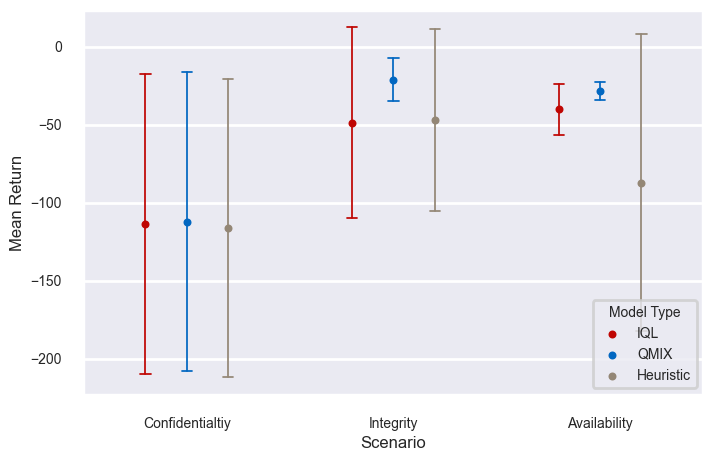

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#df_pl = pd.concat([df_cv, df_heurisitic])
df_pl = df_cv.copy()
df_pl[['scenario', 'network_size']] = df_pl['map_name'].str.split('_', expand=True)

# Sort E,M,H
df_pl.sort_values(by='map_name', key=lambda column: column.map(lambda x: sort_order.index(x)), inplace=True)


#df_pl['map_name'] = df_pl['map_name'].str.replace('_', ' ').str.title()

#fig, ax = plt.subplots()

plt.figure(figsize=(8,5))

sns.set(style='darkgrid')
paper_rc = {'lines.linewidth': 0.7, 'lines.markersize': 15, "xtick.labelsize":10, "ytick.labelsize":10, "axes.labelsize":12, "legend.fontsize":10, "legend.title_fontsize":10}      
sns.set_context("poster", rc = paper_rc)   


g = sns.pointplot(
    data=df_pl, x='scenario', y='return_mean', hue='algorithm', hue_order=['iql', 'qmix', 'heuristic'],
    join=False, dodge=.6 - .6 / 3, palette=['#BF0603',  '#0267C1', '#948776'],
    markers="o", scale=1.4, errorbar='sd', capsize=0.05, linestyles='', estimator='mean'
)
g.set(xlabel='Scenario', ylabel='Mean Return')

plt.xticks(range(len(df_pl['scenario'].unique())), ['Confidentialtiy', 'Integrity', 'Availability'])#['Small', 'Medium', 'Large'])#, 
#plt.title('Mean Return by Scenario')

handles, _ = g.get_legend_handles_labels()
labels = ['IQL', 'QMIX', 'Heuristic']

plt.legend(title="Model Type", 
            frameon=True, ncol=1, loc='lower right',
            handles=handles, labels=labels
            )   

<AxesSubplot: xlabel='return_mean', ylabel='map_name'>

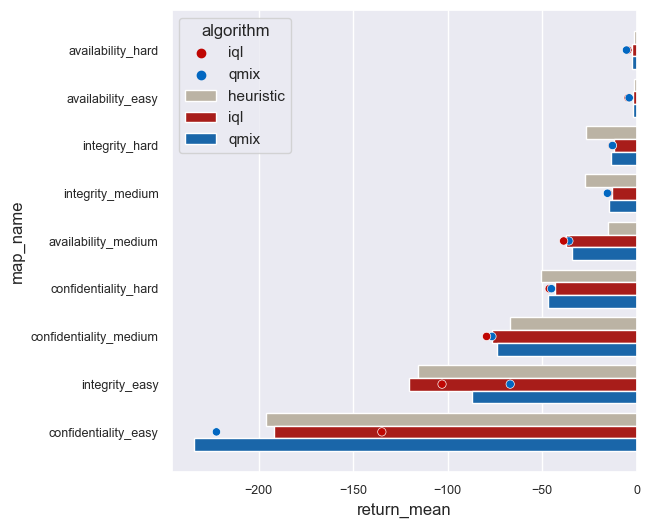

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('./datasets/phase_1_heuristic.csv')

df_sorted = df.sort_values(by=['return_mean'], ascending=False).reset_index()

# Mask out heuristic for plotting the max
rl_mask = (df_sorted['algorithm']=='iql')|(df_sorted['algorithm']=='qmix')

plt.figure(figsize=(6,6))

sns.barplot(data=df_sorted,  x='return_mean', y='map_name', hue='algorithm', orient='h', palette=['#BFB4A0', '#BF0603', '#0267C1', ])
sns.scatterplot(data=df_sorted[rl_mask],  x='return_max', y='map_name', hue='algorithm', palette=['#BF0603', '#0267C1', ])

INPUT: CSV with all runs (phase1)\
OUTPUT: CSV with max runs

In [234]:
df = pd.read_csv('./datasets/phase_1.csv')

# Returns list of rows containing max vals
def get_top_results(df):
    # iterate over the unique elements
    for s in scenarios:
        # get the corresponding row
        row = df[df['map_name'] == s]
        # get the maximum value from column B
        max_val = row['return_mean'].max()
        # get the entire row with the maximum value
        row_max = row[row['return_mean'] == max_val]
        # append the row to the list
        top_results.append(row_max)
    return top_results

# list of unique scenarios
scenarios = df['map_name'].unique()
# create a list for the output dataframes
top_results = []

iql_mask = df['algorithm'] == 'iql'
# Apply mask
df_iql = df[iql_mask]
df_qmix = df[~iql_mask]

iql_results = pd.concat(get_top_results(df_iql))
qmix_results = pd.concat(get_top_results(df_qmix))

iql_results.to_csv('./datasets/phase1_iql_max.csv')
qmix_results.to_csv('./datasets/phase1_qmix_max.csv')


In [23]:
def within_one_stdev(row):
    iql_mean = row['return_mean']
    qmix_mean = row['return_mean']
    stdev = row['return_stdev']
    if abs(iql_mean - qmix_mean) <= stdev:
        return True
    else:
        return False

df_mean['within_one_stdev'] = df.apply(within_one_stdev, axis=1)
print(df_mean)

   algorithm                map_name  return_mean  return_stdev  \
0        iql       availability_easy    -3.389821      3.278751   
1        iql       availability_hard    -3.850000      2.437045   
2        iql     availability_medium   -36.569702     26.261451   
3        iql    confidentiality_easy  -166.328988     55.769792   
4        iql    confidentiality_hard   -44.847857     24.223731   
5        iql  confidentiality_medium   -80.001190     38.443653   
6        iql          integrity_easy   -99.340417     51.958131   
7        iql          integrity_hard   -12.679702      6.364152   
8        iql        integrity_medium   -14.955893     13.914883   
9       qmix       availability_easy    -4.080060      3.362486   
10      qmix       availability_hard    -3.493899      2.215589   
11      qmix     availability_medium   -37.124603     26.517726   
12      qmix    confidentiality_easy  -225.301012     13.406933   
13      qmix    confidentiality_hard   -44.222857     23.16844

In [44]:
import json
import os
import numpy as np
import pandas as pd

root_dir = f'C:/Users/ECE/workspace/CyMARL/pymarl2/results/sacred/'

# Create empty dataframe
df = pd.DataFrame()

# Iterate through each folder
for root, dirs, files in os.walk(root_dir):

    # Check if info.json and config.json exist
    if 'info.json' in files and 'config.json' in files:

        # Read the config file
        with open(os.path.join(root, 'config.json')) as config_f:
            config = json.load(config_f)


        df_info = pd.DataFrame()
        # Loop through the config file and add the variables as columns
        for key, value in config.items():
            df_info[key] = value
            df_info['path'] = root

        # Append file info to dataset
        df = pd.concat([df, df_info])
        

seeds = df['seed'].unique()
print(f'{len(seeds)} runs have been added to the file.\n{seeds}')

df.to_csv('all_runs.csv')
#df.to_csv('senarios.csv')


337 runs have been added to the file.
[270050607 310390044 392625979 943733165 850580077  89311128   4107592
 167921169  94557417 889354254 709260962 888953836 897297007 857052845
 118830680  90309189 805003329 874433498 177796808 280568570 103695453
 748417837 998330527 463461590  21143987 630148676 966805169 612758129
 452190669 147490920 105995033 987245297 774474013 561043412 652178563
 352404252 433135288 835790851 940666537 450508946 222410794  75805802
 866471880 238657096 836005279 367626383 504379538 827113228 922578360
 166522885 659268239 360202327 939134199 901814116 106619013 178420112
 661804041 520079147 906384574  66732664  60166515 878439957 492429832
 746765074 331732318  77269494 506651583 609099543 450816557 613282978
 208428264 801944093 402247343 530177392 733036086 759664632 686731382
 761598547 809300181 432014329 738972006 807747533 337159800 908954211
 256114882 211161197 618530744 365313416 407971683  66094680  51625642
 639365822 250926319 605780644 37757954

This gets the scenario from the path

In [45]:
df = pd.read_csv('all_runs.csv')

df['path'] = df['path'].apply(lambda x: str(x.split('/')[-1].split('\\')[0]))

df_seeds = df.groupby(['seed']).first()['path']
df_seeds.to_csv('seeds.csv')


In [46]:

import csv, os

# open the csv file and read into a dictionary
word_dict = {}
with open('seeds.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        word_dict[row[0]] = row[1]

# get list of files in the directory
directory = 'C:\\Users\\ECE\\Desktop\\models'
files = os.listdir(directory)


#print(word_dict)
# loop through files, get last word from name, and check if it's in the dictionary
for file in files:
    name_parts = file.split('_')
    print(name_parts)
    last_word = name_parts[-4]
    if last_word in word_dict:
        ident = word_dict[last_word]
        words_to_keep = [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
        new_name = name_parts[0] + '_' + ident + '_' + '_'.join(name_parts[4:])
        os.rename(os.path.join(directory, file), os.path.join(directory, new_name))

['iql', 'tuned', 'confidentiality', 'easy', 'batch', 'size=128', 'buffer', 'size=10000', 'lr=0.001', '', '155730908', '', '2023-01-24', '10-26-04']
['iql', 'tuned', 'confidentiality', 'easy', 'batch', 'size=128', 'buffer', 'size=10000', 'lr=0.002', '', '241715868', '', '2023-01-24', '22-48-05']
['iql', 'tuned', 'confidentiality', 'easy', 'batch', 'size=128', 'buffer', 'size=20000', 'lr=0.001', '', '808393883', '', '2023-01-24', '14-30-04']
['iql', 'tuned', 'confidentiality', 'easy', 'batch', 'size=128', 'buffer', 'size=20000', 'lr=0.002', '', '963205677', '', '2023-01-25', '02-38-48']
['iql', 'tuned', 'confidentiality', 'easy', 'batch', 'size=128', 'buffer', 'size=5000', 'lr=0.001', '', '674826684', '', '2023-01-24', '06-39-42']
['iql', 'tuned', 'confidentiality', 'easy', 'batch', 'size=128', 'buffer', 'size=5000', 'lr=0.002', '', '529654626', '', '2023-01-24', '18-46-44']
['iql', 'tuned', 'confidentiality', 'easy', 'batch', 'size=256', 'buffer', 'size=10000', 'lr=0.001', '', '71205364